In [9]:
library(tidyverse)
library(tidymodels)
library(repr)
library(RColorBrewer)
# library(themis)

In [24]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
download.file(url, "data.mod")

# Load our dataset
chest_pain_data <- read_csv("data.mod", col_name = FALSE)
slice(chest_pain_data,1:6)

set.seed(4321)

Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_double(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_double(),
  X10 = col_double(),
  X11 = col_double(),
  X12 = col_character(),
  X13 = col_character(),
  X14 = col_double()
)



X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


In [25]:
# add colomn names
names(chest_pain_data) <- c("age", "sex",
                         "chest_pain_type",
                         "trest_bps",
                          "cholesterol",
                          "fasting_blood_sugar",
                          "resting_ecg",
                          "max_heart_rate",
                          "exercise_induced_angina",
                          "oldpeak",
                          "slope",
                          "no_vessels_colored",
                          "thal",
                          "healthy")

In [26]:
# convert all categorical variables into a factor using the as_factor() function.
chest_pain_data <- mutate(chest_pain_data, sex = as_factor(sex),
                          chest_pain_type = as_factor(chest_pain_type),
                          fasting_blood_sugar = as_factor(fasting_blood_sugar),
                          resting_ecg = as_factor(resting_ecg),
                          exercise_induced_angina = as_factor(exercise_induced_angina),
                          slope = as_factor(slope),
                          no_vessels_colored = as_factor(no_vessels_colored),
                          thal = as_factor(thal),
                          healthy = as_factor(healthy)
                          )
# slice(chest_pain_data,1:6) 

In [27]:
# split our dataset into a training dataset and a testing dataset
# Randomly take 75% of the data in the training set. 
# This will be proportional to the different number of fruit names in the dataset.

chest_pain_data_split <- initial_split(chest_pain_data, prop = 0.75, strata =chest_pain_type )  
chest_pain_data_train <- training(chest_pain_data_split)   
chest_pain_data_test <- testing(chest_pain_data_split)

 slice(chest_pain_data_train,1:6) 
 slice(chest_pain_data_test,1:6) 

age,sex,chest_pain_type,trest_bps,cholesterol,fasting_blood_sugar,resting_ecg,max_heart_rate,exercise_induced_angina,oldpeak,slope,no_vessels_colored,thal,healthy
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0
62,0,4,140,268,0,2,160,0,3.6,3,2.0,3.0,3
63,1,4,130,254,0,2,147,0,1.4,2,1.0,7.0,2


age,sex,chest_pain_type,trest_bps,cholesterol,fasting_blood_sugar,resting_ecg,max_heart_rate,exercise_induced_angina,oldpeak,slope,no_vessels_colored,thal,healthy
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
57,0,4,120,354,0,0,163,1,0.6,1,0.0,3.0,0
56,0,2,140,294,0,2,153,0,1.3,2,0.0,3.0,0
44,1,2,120,263,0,0,173,0,0.0,1,0.0,7.0,0
52,1,3,172,199,1,0,162,0,0.5,1,0.0,7.0,0


In [28]:
# cross validation
vfold <- vfold_cv(chest_pain_data_train, v=5, strata = chest_pain_type)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.4594595
kap,multiclass,0.1103096


          Truth
Prediction  1  2  3  4
         1  0  0  0  0
         2  1  0  2  2
         3  1  6  9  9
         4  3  7  9 25

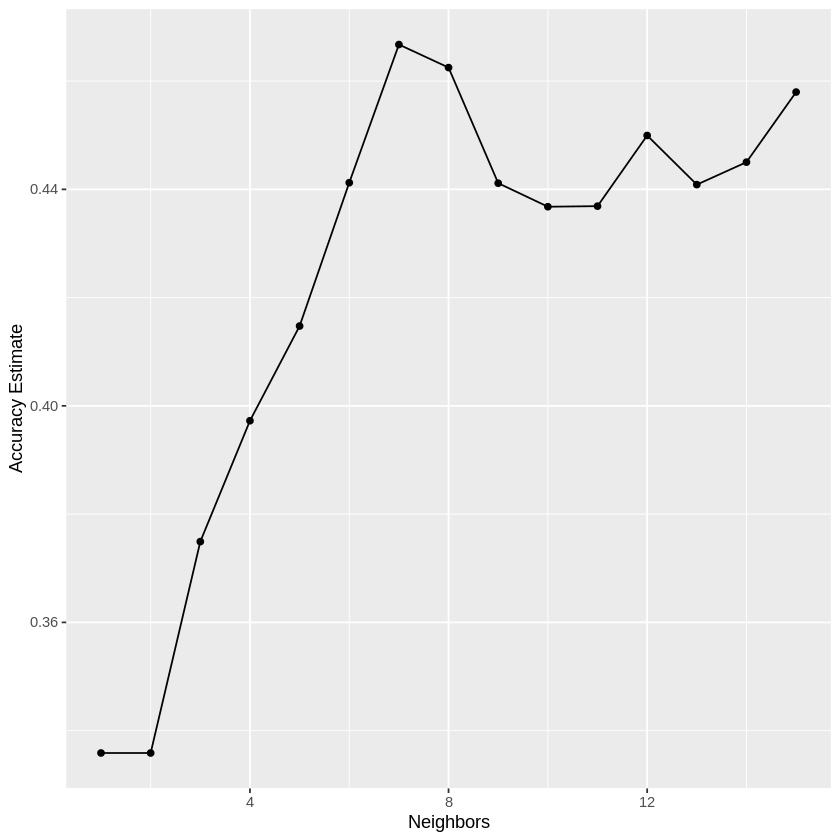

In [29]:
# recipe and standardization
cp_recipe <- recipe(chest_pain_type~age+trest_bps+cholesterol+max_heart_rate, data = chest_pain_data_train) %>%
  #  step_upsample(Class, over_ratio = 1, skip = FALSE) %>%         # fix imbalances
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

# model
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

# workflow
knn_result <- workflow() %>%
    add_recipe(cp_recipe) %>%
    add_model(knn_tune) %>%
    tune_grid(resamples = vfold, grid = 50) %>%
    collect_metrics()

# accuracy
accuracies <- knn_result %>%
    filter(.metric == "accuracy")

# accuracy plot
cross_val_plot <- accuracies %>%
    ggplot(aes(x=neighbors, y=mean)) +
    geom_point()+
    geom_line() +
    labs(x="Neighbors", y="Accuracy Estimate")
cross_val_plot

# build model with k=11
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 11) %>%
    set_engine("kknn") %>%
    set_mode("classification")

# new workflow
fit <- workflow() %>%
    add_recipe(cp_recipe) %>%
    add_model(knn_spec) %>%
    fit(data=chest_pain_data_train)

# predict
cp_predictions <- predict(fit, chest_pain_data_test) %>%
    bind_cols(chest_pain_data_test)

# compute accuracy
metrics <- cp_predictions %>%
    metrics(truth = chest_pain_type, estimate = .pred_class)
metrics

# confusion matrix
confusion <- cp_predictions %>%
    conf_mat(truth = chest_pain_type, estimate = .pred_class)
confusion